# Analyse de Fourier pour les séries temporelles

Comment repérer des périodicités dans une série temporelle ? 

Nous n'avons vu que des cas évidents (saisonnalité annuelle, hebdomadaire, journalière) mais il est possible d'avoir des périodicités plus subtiles (une périodicité de 10 jours par exemple, ou une conjonction de plusieurs périodicités : par exemple, le trafic de vélo augmente le matin et le soir, mais aussi en semaine et en été).

Pour repérer ces périodicités, les maths nous offrent un microscope très puissant : l'analyse de Fourier.

## Fourier 101

L'analyse de Fourier repose sur une idée très simple : toute fonction périodique peut se décomposer en une somme éventuellement infinie de fonctions sinusoïdales (des ondes).

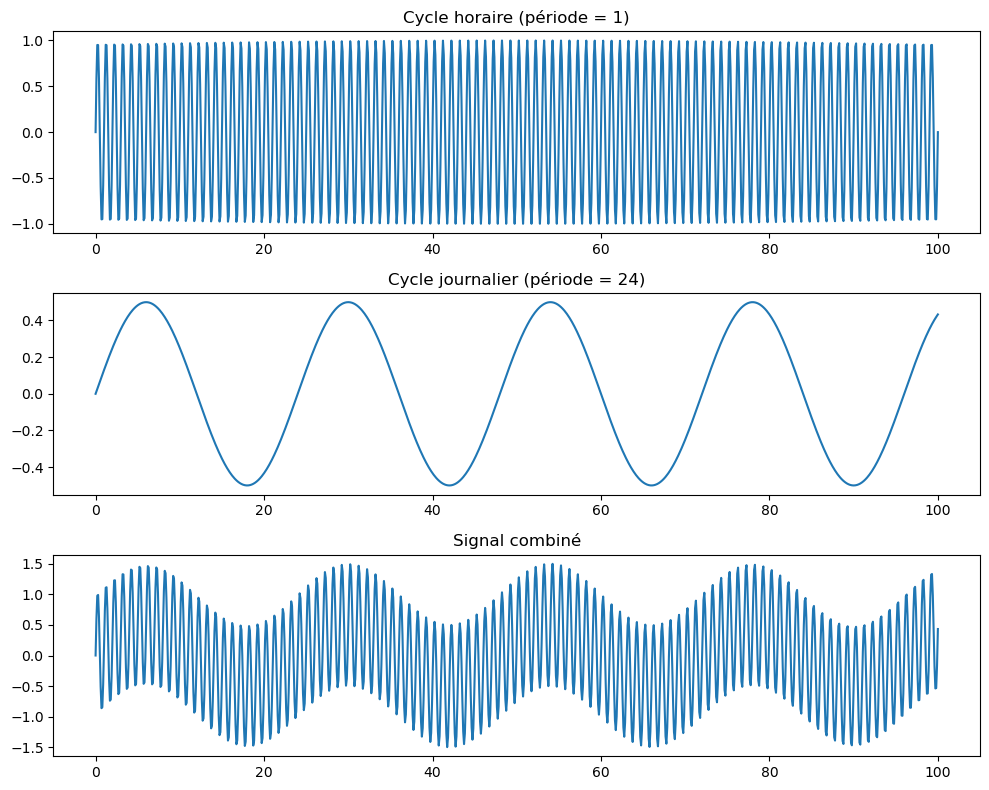

In [45]:
import numpy as np 
import matplotlib.pyplot as plt 

# Exemple d'une fonction périodique
t = np.linspace(0, 100, 1000)
hourly_cycle = np.sin(2 * np.pi * t)  # Période de 1 unité de temps
daily_cycle = 0.5 * np.sin(2 * np.pi * t / 24)  # Période de 24 unités de temps
combined_signal = hourly_cycle + daily_cycle

fig, axs = plt.subplots(3, 1, figsize=(10, 8))
axs[0].plot(t, hourly_cycle)
axs[0].set_title('Cycle horaire (période = 1)')
axs[1].plot(t, daily_cycle)
axs[1].set_title('Cycle journalier (période = 24)')
axs[2].plot(t, combined_signal)
axs[2].set_title('Signal combiné')
plt.tight_layout()
plt.show()

L'analyse de Fourier permet de déconstruire une fonction périodique en ses composantes sinusoïdales, chacune caractérisée par une fréquence, une amplitude et une phase.

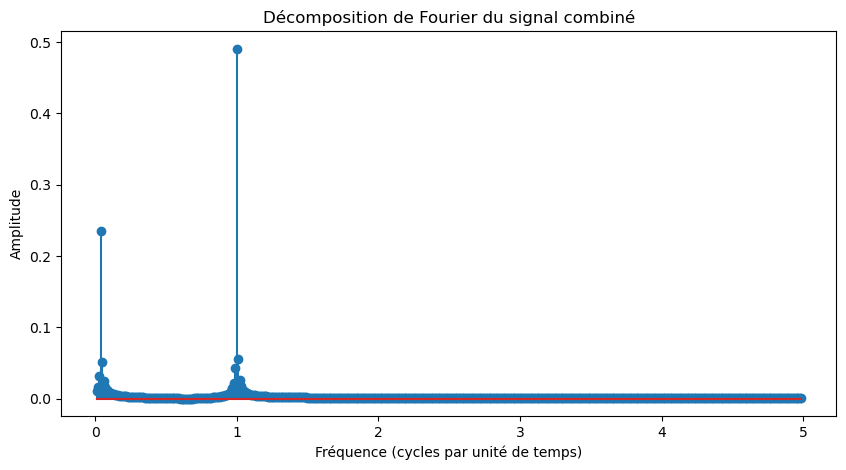

In [46]:
# Transformée de Fourier
fft_result = np.fft.fft(combined_signal)
fft_freq = np.fft.fftfreq(len(t), d=(t[1]-t[0]))  # Fréquences

# Amplitude (module)
amplitude = np.abs(fft_result) / len(t)

# On ne garde que les fréquences positives
pos_mask = fft_freq > 0
fft_freq = fft_freq[pos_mask]
amplitude = amplitude[pos_mask]

# Visualisation
plt.figure(figsize=(10,5))
plt.stem(fft_freq, amplitude)
plt.xlabel('Fréquence (cycles par unité de temps)')
plt.ylabel('Amplitude')
plt.title('Décomposition de Fourier du signal combiné')
plt.show()

On voit un pic à 1 : une période par heure -> cycle horaire

Et un autre pic à 1/24 : une période toutes les 24h -> cycle journalier

## Décomposition en fréquences d'une série temporelle

On va prendre un exemple de la vie réelle : la consommation électrique horaire en Allemagne sur plusieurs années.

source des données : https://data.open-power-system-data.org/time_series/

In [47]:
import pandas as pd 

df = pd.read_csv("de_load.csv")
df["utc_timestamp"] = pd.to_datetime(df["utc_timestamp"])
df = df.set_index("utc_timestamp")

<Axes: title={'center': 'Consommation électrique horaire en Allemagne'}, xlabel='utc_timestamp'>

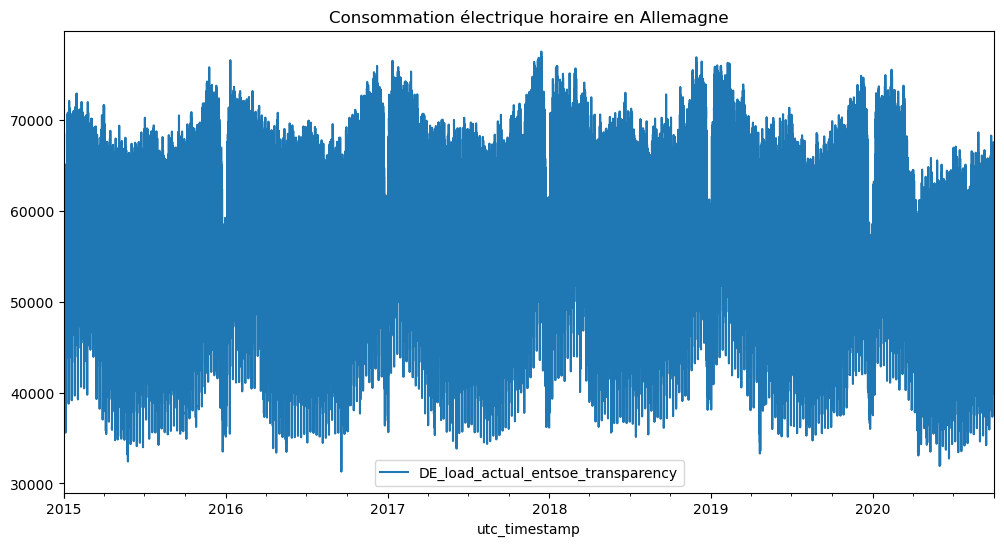

In [48]:
df.plot(figsize=(12,6), title="Consommation électrique horaire en Allemagne")

<Axes: title={'center': 'Première semaine'}, xlabel='utc_timestamp'>

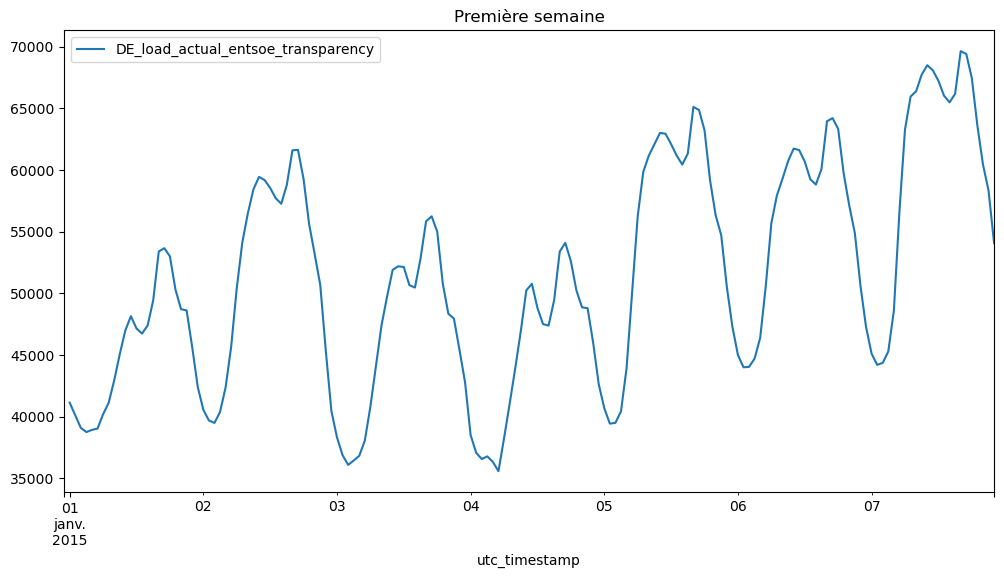

In [49]:
df.iloc[0:24*7].plot(figsize=(12,6), title="Première semaine")

Plusieurs périodes coexistent ...

On va utiliser le microscope de Fourier pour les repérer.


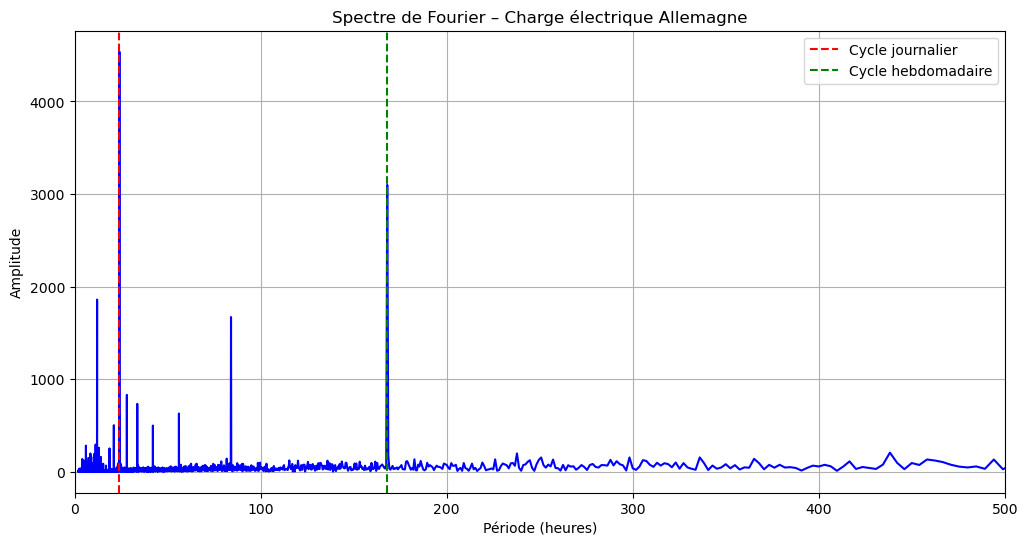

In [50]:
import numpy as np
import matplotlib.pyplot as plt

signal = df.iloc[1:, 0].values  
signal_centered = signal - np.mean(signal)

# FFT
N = len(signal_centered)
fft_vals = np.fft.fft(signal_centered)
freqs = np.fft.fftfreq(N, d=1)  # échantillonnage horaire

# Amplitude
amp = np.abs(fft_vals) / N

# Fréquences positives
mask = freqs > 0
freqs = freqs[mask]
amp = amp[mask]

# Conversion en période (heures)
periods = 1 / freqs

# Zoom et visualisation avec ligne et log
plt.figure(figsize=(12,6))
plt.plot(periods, amp, color='blue')
plt.xlim(0, 500)          # cycles jusqu'à ~500h (≈3 semaines)
plt.xlabel("Période (heures)")
plt.ylabel("Amplitude")
plt.title("Spectre de Fourier – Charge électrique Allemagne")
plt.grid(True)

plt.axvline(24, color='red', linestyle='--', label="Cycle journalier")
plt.axvline(168, color='green', linestyle='--', label="Cycle hebdomadaire")
plt.legend()

plt.show()



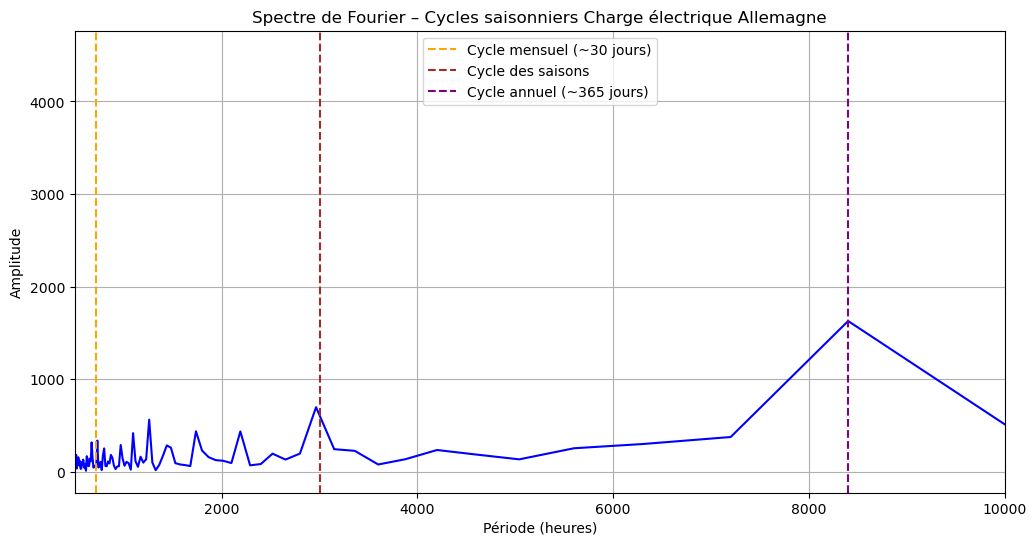

In [58]:
import numpy as np
import matplotlib.pyplot as plt

signal = df.iloc[1:, 0].values
signal_centered = signal - np.mean(signal)

# FFT
N = len(signal_centered)
fft_vals = np.fft.fft(signal_centered)
freqs = np.fft.fftfreq(N, d=1)  # échantillonnage horaire

# Amplitude
amp = np.abs(fft_vals) / N

# Fréquences positives
mask = freqs > 0
freqs = freqs[mask]
amp = amp[mask]

# Conversion en période (heures)
periods = 1 / freqs

# Visualisation des cycles longs (saisonniers)
plt.figure(figsize=(12,6))
plt.plot(periods, amp, color='blue')
plt.xlim(500, 10000)  # zoom sur cycles longs (≈3 semaines à ~1 an)
plt.xlabel("Période (heures)")
plt.ylabel("Amplitude")
plt.title("Spectre de Fourier – Cycles saisonniers Charge électrique Allemagne")
plt.grid(True)

# Repères des cycles approximatifs
plt.axvline(24*30, color='orange', linestyle='--', label="Cycle mensuel (~30 jours)")
plt.axvline(3000, color='brown', linestyle='--', label="Cycle des saisons")
plt.axvline(8400, color='purple', linestyle='--', label="Cycle annuel (~365 jours)")
plt.legend()

plt.show()


# Fourier en pratique


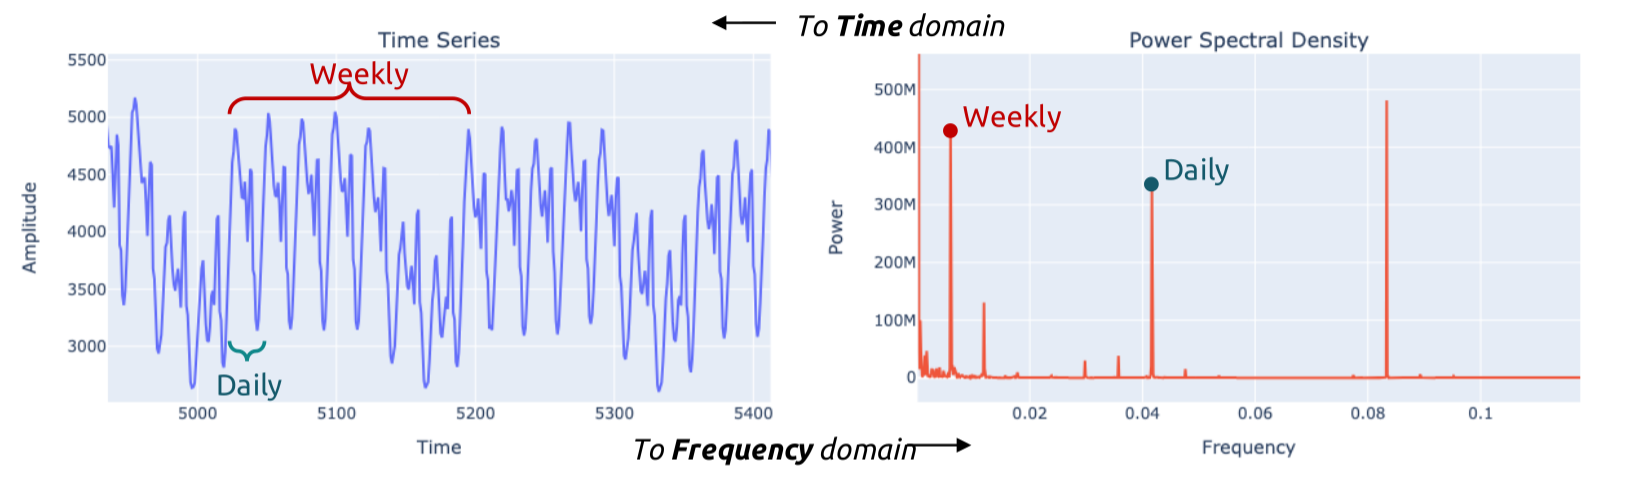

- Choisir le m de SARIMA(p,d,q)(P,D,Q)m
- Créer des features basées sur des fonctions sinusoïdales pour capturer des périodicités dans des modèles multivariés

    Pour une période `m` :

    $$
    \sin\left(\frac{2\pi k t}{m}\right), \quad
    \cos\left(\frac{2\pi k t}{m}\right)
    $$

    - `t` : index temporel (0, 1, 2, ...)
    - `m` : période saisonnière
    - `k` : ordre harmonique (nombre d'occurence par période)


- Peut aussi être utilisé pour du filtrage de signal (éliminer le bruit haute fréquence par exemple).

Pour une intuition plus profonde sur l'analyse de Fourier, je ne peux que vous recommander l'excellent cours de 3Blue1Brown : [Essence of Fourier Series](https://www.youtube.com/watch?v=spUNpyF58BY&t=51s)